In [2]:
from __future__ import annotations

# ======================
# 0) Imports & constants
# ======================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from scipy.linalg import block_diag
from IPython.display import display
import control as ct

# Physical constants
R_GAS = 8.314462618        # J/(mol·K)
@dataclass
class PhysParams:
    F: float = 96485.33212  # C/mol
    t_plus: float = 0.38    # transference number
PP = PhysParams()

# ================================================
# 1) Sizing, indexing & state names (DO NOT CHANGE)
# ================================================
IDX = {
    "cn": slice(0, 2),      # [cn1, cn2]
    "cp": slice(2, 4),      # [cp1, cp2]
    "ce": slice(4, 7),      # [ce1, ce2, ce3]
    "cn_surf": 1,           # negative surface CV  (cn2)
    "cp_surf": 3,           # positive surface CV  (cp2)  <-- global index
    "ce_left": 4,           # ce1 (anode side)
    "ce_right": 6,          # ce3 (cathode side)
}
STATE_NAMES = ['cn1', 'cn2', 'cp1', 'cp2', 'ce1', 'ce2', 'ce3']

# ==========================================
# 2) Solid & Electrolyte block construction
# ==========================================
def build_An(Dn: float, Rn: float) -> np.ndarray:
    """
    2×2 negative-electrode solid diffusion stencil (2 CVs).
    s = Dn / Rn^2; off-diagonals ±8s; row sums = 0.
    """
    s = Dn / (Rn**2)
    A = np.zeros((2, 2))
    A[0, 0], A[0, 1] = -8*s,  8*s
    A[1, 0], A[1, 1] =  8*s, -8*s
    return A



def build_Bn(Dn: float, Rn: float, a: float, A: float, L_n: float) -> np.ndarray:
    """
    2×1 input for negative solid block. Current enters at surface node only.
    Scale ~ 1/(R * F * a * D * A * L).
    """
    b = np.zeros((2, 1))
    b[-1, 0] = 4.0 / (Dn * Rn * PP.F * a * A * L_n)
    return b

def build_Ap(Dp: float, Rp: float) -> np.ndarray:
    """
    2×2 positive-electrode solid diffusion stencil (2 CVs).
    Same form as An with s = Dp / Rp^2.
    """
    s = Dp / (Rp**2)
    A = np.zeros((2, 2))
    A[0, 0], A[0, 1] = -8*s,  8*s
    A[1, 0], A[1, 1] =  8*s, -8*s
    return A

def build_Bp(Dp: float, Rp: float, a: float, A: float, L_p: float) -> np.ndarray:
    """
    2×1 input for positive solid block. Current enters at surface node only.
    """
    b = np.zeros((2, 1))
    b[-1, 0] = -(4.0 / (Dp * Rp * PP.F * a * A * L_p))
    return b

# =========================================================
# 2) Electrolyte block (3×3) and input (3×1)
# =========================================================
def build_Ae(D_e: float, epsilon: float,
             L_minus: float, Lsep: float, L_plus: float) -> np.ndarray:
    """
    3×3 electrolyte diffusion/coupling across [n | s | p] nodes.
    Uses K = D_e/epsilon and interface weight w(La,Lb)=4K/(La+Lb)^2.
    """
    Ae = np.zeros((3, 3))
    K = D_e / epsilon

    def w_intf(La, Lb):
        return K * 4.0 / ((La + Lb)**2)

    w11 = w_intf(L_minus, Lsep)   # n-s interface
    w12 = w_intf(L_plus,  Lsep)   # s-p interface

    Ae[0, 0] =  w11
    Ae[0, 1] = -w11
    Ae[1, 0] = -w11
    Ae[1, 1] =  (w11 + w12)
    Ae[1, 2] = -w12
    Ae[2, 1] = -w12
    Ae[2, 2] =  w12
    return Ae

# def build_Ae(D_e: float, epsilon: float,
#              L_minus: float, Lsep: float, L_plus: float) -> np.ndarray:
#     """
#     3×3 electrolyte diffusion/coupling across [n | s | p] nodes.
#     Uses K = D_e/epsilon and interface weight w(La,Lb)=4K/(La+Lb)^2.

#     IMPORTANT: For diffusion x' = K * Laplacian(x),
#     the discrete operator must have NEGATIVE diagonal and POSITIVE off-diagonals.
#     """
#     K = D_e / epsilon

#     def w_intf(La, Lb):
#         return K * 4.0 / ((La + Lb)**2)

#     w_ns = w_intf(L_minus, Lsep)  # n-s interface
#     w_sp = w_intf(L_plus,  Lsep)  # s-p interface

#     Ae = np.array([
#         [ -w_ns,  +w_ns,     0.0 ],
#         [ +w_ns, -(w_ns+w_sp), +w_sp ],
#         [  0.0,   +w_sp,    -w_sp ]
#     ], dtype=float)
#     return Ae

def build_Be(L_minus: float, Lsep: float, L_plus: float,
             eps: float, A: float, t_plus: float) -> np.ndarray:
    """
    3×1 electrolyte input vector.
    Current enters at negative (index 0) and leaves at positive (index 2).
    Magnitude scaled by (1 - t_plus)/(0.5 * F * A * (L_region + Lsep) * eps).
    """
    b = np.zeros((3, 1))
    s1 = (1.0 - t_plus) / (0.5 * PP.F * A * (L_minus + Lsep) * eps)  # negative side source @ ce1
    s3 = -((1.0 - t_plus) / (0.5 * PP.F * A * (L_plus  + Lsep) * eps))  # positive side sink   @ ce3
    b[0, 0] = s1
    b[2, 0] = s3
    return b

# =========================================================
# 3) System assembly: global A (7×7) and B (7×1)
# =========================================================
def assemble_system(params: dict):
    """
    Build sub-blocks and assemble:
        A = blkdiag(An, Ap, Ae)
        B = [Bn; Bp; Be]
    Returns: A, B, (An, Ap, Ae, Bn, Bp, Be)
    Required params keys:
      Dn, Rn, Dp, Rp,
      a_s_n, a_s_p, A,       # <-- single cross-sectional area A
      L1, L2, L3,
      D_e, eps, A_e
    """
    # --- unpack
    Dn, Rn = params["Dn"], params["Rn"]
    Dp, Rp = params["Dp"], params["Rp"]
    L1, L2, L3 = params["L1"], params["L2"], params["L3"]   # n, sep, p thicknesses
    a_s_n, a_s_p = params["a_s_n"], params["a_s_p"]
    A           = params["A"]                                
    D_e         = params["D_e"]
    eps         = params["eps"]

    # --- sub-blocks (note A with L1/L3)
    An = build_An(Dn, Rn)
    Ap = build_Ap(Dp, Rp)
    Bn = build_Bn(Dn,Rn, a_s_n, A, L1)
    Bp = build_Bp(Dp, Rp, a_s_p, A, L3)
    Ae = build_Ae(D_e, eps, L1, L2, L3)
    Be = build_Be(L1, L2, L3, eps, A, PP.t_plus)

    # --- global A, B
    A_mat = block_diag(An, Ap, Ae).astype(float)
    B_mat = np.vstack([Bn, Bp, Be]).astype(float)
    return A_mat, B_mat, (An, Ap, Ae, Bn, Bp, Be)


# =========================================================
# 4) Matrix display helpers
# =========================================================
def show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B):
    """Pretty-print all matrices as DataFrames."""
    def df(M, r, c): return pd.DataFrame(M, index=r, columns=c)
    print("\n NEGATIVE ELECTRODE (An, Bn)"); display(df(An, ['cn1','cn2'], ['cn1','cn2'])); display(df(Bn, ['cn1','cn2'], ['u']))
    print("\n POSITIVE ELECTRODE (Ap, Bp)"); display(df(Ap, ['cp1','cp2'], ['cp1','cp2'])); display(df(Bp, ['cp1','cp2'], ['u']))
    print("\n ELECTROLYTE (Ae, Be)");       display(df(Ae, ['ce1','ce2','ce3'], ['ce1','ce2','ce3'])); display(df(Be, ['ce1','ce2','ce3'], ['u']))
    print("\n (A, B)");                     display(df(A, STATE_NAMES, STATE_NAMES)); display(df(B, STATE_NAMES, ['u']))
    print(f"\nMatrix Shapes ➤  A: {A.shape},  B: {B.shape}")

def plot_states_grouped(t: np.ndarray, X: np.ndarray):
    """
    Grouped state plots.
    Parameters
    ----------
    t : (T,)  time grid
    X : (T,7) states
    """
    fig, axs = plt.subplots(3, 1, figsize=(9, 9), sharex=True)
    axs[0].plot(t, X[:, IDX["cn"]]); axs[0].set_ylabel("c_n"); axs[0].set_title("Negative solid"); axs[0].grid(True, alpha=0.3); axs[0].legend(['cn1','cn2'], ncol=2, fontsize=9)
    axs[1].plot(t, X[:, IDX["cp"]]); axs[1].set_ylabel("c_p"); axs[1].set_title("Positive solid"); axs[1].grid(True, alpha=0.3); axs[1].legend(['cp1','cp2'], ncol=2, fontsize=9)
    axs[2].plot(t, X[:, IDX["ce"]]); axs[2].set_ylabel("c_e"); axs[2].set_xlabel("t [s]"); axs[2].set_title("Electrolyte"); axs[2].grid(True, alpha=0.3); axs[2].legend(['ce1','ce2','ce3'], ncol=3, fontsize=9)
    plt.tight_layout(); plt.show()


def report_extrema(X: np.ndarray):
    """Print min/max per block for X with shape (T, 7)."""
    mm = lambda A: (float(np.min(A)), float(np.max(A)))
    cn_min, cn_max = mm(X[:, IDX["cn"]]); cp_min, cp_max = mm(X[:, IDX["cp"]]); ce_min, ce_max = mm(X[:, IDX["ce"]])
    print(f"c_n  min/max: {cn_min:.3g} / {cn_max:.3g}")
    print(f"c_p  min/max: {cp_min:.3g} / {cp_max:.3g}")
    print(f"c_e  min/max: {ce_min:.3g} / {ce_max:.3g}")

# =========================================================
# Example (run to test)
# =========================================================
if __name__ == "__main__":
    params = dict(
        Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
        a_s_n=1.0e6, a_s_p=1.0e6, A =1.0,
        L1=25e-6, L2=20e-6, L3=25e-6,
        D_e=7.23e-10, eps=0.30,
    )

    A, B, (An, Ap, Ae, Bn, Bp, Be) = assemble_system(params)
    show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B)

    # Optional: view symbolic structure
    # show_symbolic_matrices()



 NEGATIVE ELECTRODE (An, Bn)


,cn1,cn2
cn1,-0.0032,0.0032
cn2,0.0032,-0.0032


,u
cn1,0.000000e+00
cn2,3.316566e+13



 POSITIVE ELECTRODE (Ap, Bp)


,cp1,cp2
cp1,-0.0032,0.0032
cp2,0.0032,-0.0032


,u
cp1,0.000000e+00
cp2,-3.316566e+13



 ELECTROLYTE (Ae, Be)


,ce1,ce2,ce3
ce1,4.760494,-4.760494,0.000000
ce2,-4.760494,9.520988,-4.760494
ce3,0.000000,-4.760494,4.760494


,u
ce1,0.951977
ce2,0.000000
ce3,-0.951977



 (A, B)


,cn1,cn2,cp1,cp2,ce1,ce2,ce3
cn1,-0.0032,0.0032,0.0000,0.0000,0.000000,0.000000,0.000000
cn2,0.0032,-0.0032,0.0000,0.0000,0.000000,0.000000,0.000000
cp1,0.0000,0.0000,-0.0032,0.0032,0.000000,0.000000,0.000000
cp2,0.0000,0.0000,0.0032,-0.0032,0.000000,0.000000,0.000000
ce1,0.0000,0.0000,0.0000,0.0000,4.760494,-4.760494,0.000000
ce2,0.0000,0.0000,0.0000,0.0000,-4.760494,9.520988,-4.760494
ce3,0.0000,0.0000,0.0000,0.0000,0.000000,-4.760494,4.760494


,u
cn1,0.000000e+00
cn2,3.316566e+13
cp1,0.000000e+00
cp2,-3.316566e+13
ce1,9.519774e-01
ce2,0.000000e+00
ce3,-9.519774e-01



Matrix Shapes ➤  A: (7, 7),  B: (7, 1)


c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\envenv\Lib\site-packages\control\timeresp.py:1197: RuntimeWarning: overflow encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\envenv\Lib\site-packages\control\timeresp.py:1197: RuntimeWarning: invalid value encountered in matmul
  xout[:, i] = (Ad @ xout[:, i-1]
c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\envenv\Lib\site-packages\control\timeresp.py:1199: RuntimeWarning: invalid value encountered in matmul
  yout = C @ xout + D @ U


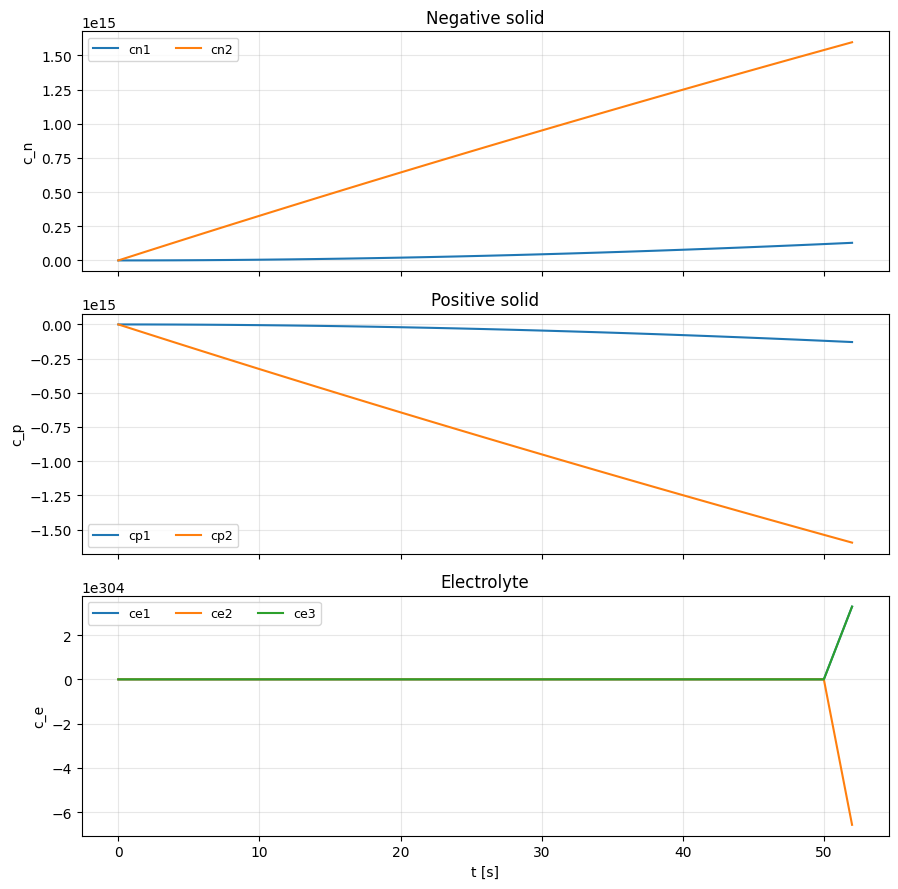

c_n  min/max: nan / nan
c_p  min/max: nan / nan
c_e  min/max: nan / nan


In [3]:
# ==============================
# 5) Simulation (forced_response)
# ==============================
def simulate_states_forced(A: np.ndarray, B: np.ndarray,
                           T: np.ndarray, U: np.ndarray, x0: np.ndarray) -> np.ndarray:
    """
    Simulate x' = A x + B u(t) with python-control forced_response.

    Returns
    -------
    X_TN : (T, n) state trajectory
    """
    sys = ct.ss(A, B, np.eye(A.shape[0]), 0)  # C = I so Y == X if needed
    resp = ct.forced_response(sys, T, U, X0=x0)
    if isinstance(resp, tuple) and len(resp) == 3:
        T_out, Y_out, X_out = resp
        X_TN = X_out.T
    else:
        T_out, Y_out = resp
        X_TN = Y_out.T  # because C = I
    assert X_TN.shape == (len(T), A.shape[0])
    return X_TN


# Time grid & input (SISO): U must be array with shape (len(T),) or (1,len(T))
T = np.linspace(0.0, 2000.0, 1001)  # seconds
I_step = 1.0  # A
U = I_step * np.ones_like(T)        # <-- numeric array (not a function)

# Initial condition per your note: cn=0, cp=1, ce=0
x0 = np.zeros(7)
x0[IDX["cn"]] = 0.0
x0[IDX["cp"]] = 1.0
x0[IDX["ce"]] = 0.0

# x0[IDX["cn"]] = 0.2
# x0[IDX["cp"]] = 0.9
# x0[IDX["ce"]] = 1000.0
    
# State-space with C = I (so outputs equal states), D = 0
sys = ct.ss(A, B, np.eye(7), 0)

# Forced response returns (T, Y, X)
resp = ct.forced_response(sys, T, U, X0=x0)

if isinstance(resp, tuple) and len(resp) == 3:
    T, Y, X = resp
    X_mat = X            # shape (n, len(T))
else:
    T, Y = resp
    X_mat = Y            # outputs == states since C = I

# Your plotting/reporting expect X as (len(T), n)
plot_states_grouped(T, X_mat.T)
report_extrema(X_mat.T)

In [4]:
# ============================
# 6) Voltage layer (two forms)
# ============================

# # example: polynomial OCPs (replace coeff arrays with yours)
# you’ll need chemistry-specific fits or your own OCV data.
# OCP_P_COEFFS = np.array([a5,a4,a3,a2,a1,a0])  # Up(xp) = a5 xp^5 + ... + a0
# OCP_N_COEFFS = np.array([b5,b4,b3,b2,b1,b0])  # Un(xn) = b5 xn^5 + ... + b0

# def ocp_p_poly(xp): return np.polyval(OCP_P_COEFFS, np.clip(xp,1e-6,1-1e-6))
# def ocp_n_poly(xn): return np.polyval(OCP_N_COEFFS, np.clip(xn,1e-6,1-1e-6))

# # then call:
# V_eq40, C_eq40 = voltage_eq40(T, XT, U_vec, vpar, ocp_p=ocp_p_poly, ocp_n=ocp_n_poly)
# V_espm, C_espm = voltage_espm(T, XT, U_vec, vpar, ocp_p=ocp_p_poly, ocp_n=ocp_n_poly)


# vpar.R_ohm = Re + Rf
# vpar.R_ohm = vpar.Re + vpar.Rf
# V_espm_no_ln, _ = voltage_espm(T, XT, U_vec, vpar, include_ln=False)




# ---- OCPs (safe placeholders). Replace with fits when ready. ----------
def ocp_p_safe(xp: np.ndarray) -> np.ndarray:
    """Cathode OCP [V], smooth & bounded for quick demos."""
    xp = np.clip(xp, 1e-6, 1-1e-6)
    return 4.15 - 0.12*np.tanh((xp - 0.60)/0.08)

def ocp_n_safe(xn: np.ndarray) -> np.ndarray:
    """Anode OCP [V], smooth & bounded for quick demos."""
    xn = np.clip(xn, 1e-6, 1-1e-6)
    return 0.10 + 0.80*(1/(1 + np.exp(-(xn-0.50)/0.04)))

# ---- Voltage parameters -----------------------------------------------
@dataclass
class VParams:
    # geometry / area
    A: float = 1.0
    L_n: float = 25e-6
    L_p: float = 25e-6
    a_s_n: float = 1.0e6
    a_s_p: float = 1.0e6
    # kinetics (tune for your cell)
    k_n: float = 2.0e-11
    k_p: float = 2.0e-11
    cs_n_max: float = 3.1e4
    cs_p_max: float = 5.1e4
    # electrolyte & factors
    ce0: float = 1000.0
    t_plus: float = PP.t_plus
    nu_T: float = 1.0
    k_f: float = 1.0  # Eq.40 factor on ln term
    # ohmics
    Re: float = 0.0
    Rf: float = 0.0
    R_ohm: float = 0.0
    # temperature
    T: float = 298.15
    # interpretation of ce states
    ce_is_deviation: bool = True  # True ⇒ ce_actual = ce0 + ce_state

def _extract_surface_and_ce(X_TN: np.ndarray, vp: VParams):
    """
    Return surface stoichiometries and end electrolyte concentrations.
    ce handling: if `ce_is_deviation`, actual = ce0 + state.
    """
    xp = np.clip(X_TN[:, IDX["cp_surf"]], 1e-9, 1-1e-9)
    xn = np.clip(X_TN[:, IDX["cn_surf"]], 1e-9, 1-1e-9)
    ceL_raw = X_TN[:, IDX["ce_left"]]
    ceR_raw = X_TN[:, IDX["ce_right"]]
    ceL = (vp.ce0 + ceL_raw) if vp.ce_is_deviation else ceL_raw
    ceR = (vp.ce0 + ceR_raw) if vp.ce_is_deviation else ceR_raw
    ceL = np.clip(ceL, 1e-9, None)
    ceR = np.clip(ceR, 1e-9, None)
    return xp, xn, ceL, ceR

def _bv_eta_terms(I: np.ndarray, xp: np.ndarray, xn: np.ndarray,
                  ceL: np.ndarray, ceR: np.ndarray, vp: VParams):
    """
    Compute symmetric BV overpotentials via closed-form asinh.
    """
    F = PP.F
    Sp = vp.a_s_p * vp.A * vp.L_p
    Sn = vp.a_s_n * vp.A * vp.L_n
    ce_kin = 0.5*(ceL + ceR)
    ce_kin = np.clip(ce_kin, 0.2*vp.ce0, 5.0*vp.ce0)  # guardrails for toy dynamics
    mp = I / (F * vp.k_p * Sp * vp.cs_p_max * np.sqrt(ce_kin) * np.sqrt(xp*(1-xp)))
    mn = I / (F * vp.k_n * Sn * vp.cs_n_max * np.sqrt(ce_kin) * np.sqrt(xn*(1-xn)))
    eta_p = (2.0*R_GAS*vp.T/F) * np.arcsinh(0.5*mp)
    eta_n = (2.0*R_GAS*vp.T/F) * np.arcsinh(0.5*mn)
    return eta_p, eta_n

def voltage_eq40(T: np.ndarray, X_TN: np.ndarray, I: np.ndarray, vp: VParams,
                 ocp_p=ocp_p_safe, ocp_n=ocp_n_safe, ln_orientation: str = "right_over_left"):
    """
    Eq. 40 from your paper screenshot:
        V = U(x) + η(I) ± (2RT/F)(1-t⁺) k_f ln(ceR/ceL) − (Re+Rf) I
    We compute η(I) via BV asinh terms for identifiability and robustness.
    """
    I = np.asarray(I).reshape(-1)
    xp, xn, ceL, ceR = _extract_surface_and_ce(X_TN, vp)
    Up, Un = ocp_p(xp), ocp_n(xn)
    eta_p, eta_n = _bv_eta_terms(I, xp, xn, ceL, ceR, vp)
    eta_sum = eta_p + eta_n

    ln_arg = (ceR/ceL) if ln_orientation == "right_over_left" else (ceL/ceR)
    dphi_e = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.k_f * np.log(ln_arg)
    ohmic  = -(vp.Re + vp.Rf) * I

    V = (Up - Un) + eta_sum + dphi_e + ohmic
    C = {"Udiff":Up-Un, "eta_sum":eta_sum, "dphi_e":dphi_e, "ohmic":ohmic, "V":V,
         "xp":xp, "xn":xn, "ceL":ceL, "ceR":ceR}
    return V, C

# def voltage_espm(T: np.ndarray, X_TN: np.ndarray, I: np.ndarray, vp: VParams,
#                  ocp_p=ocp_p_safe, ocp_n=ocp_n_safe, include_ln: bool = True):
#     """
#     ESPM/Review form:
#         V = Up−Un + 2RT/F[asinh(mp/2)+asinh(mn/2)]
#             + 2RT/F(1−t⁺)ν ln(ceR/ceL) − I R_ohm
#     """
#     I = np.asarray(I).reshape(-1)
#     xp, xn, ceL, ceR = _extract_surface_and_ce(X_TN, vp)
#     Up, Un = ocp_p(xp), ocp_n(xn)
#     eta_p, eta_n = _bv_eta_terms(I, xp, xn, ceL, ceR, vp)
#     eta_sum = eta_p + eta_n
#     dphi_e  = (2.0*R_GAS*vp.T/PP.F) * (1.0 - vp.t_plus) * vp.nu_T * np.log(ceR/ceL) if include_ln else 0.0
#     ohmic   = -vp.R_ohm * I
#     V = (Up - Un) + eta_sum + dphi_e + ohmic
#     C = {"Udiff":Up-Un, "eta_p":eta_p, "eta_n":eta_n, "eta_sum":eta_sum,
#          "dphi_e":dphi_e, "ohmic":ohmic, "V":V, "xp":xp, "xn":xn, "ceL":ceL, "ceR":ceR}
#     return V, C

# =========================
# 7) Voltage visual helpers
# =========================
def plot_voltage_compare(T, V1, V2, lab1="Eq.40", lab2="ESPM/Review"):
    """Overlay two voltage traces for quick comparison."""
    plt.figure(figsize=(9, 4.7))
    plt.plot(T, V1); plt.plot(T, V2)
    plt.xlabel("t [s]"); plt.ylabel("Voltage [V]")
    plt.title("Terminal voltage")
    # plt.legend([lab1, lab2]); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

def plot_voltage_contribs(T, C, title="Voltage contributions"):
    """Plot Udiff, η-sum, electrolyte ln-term, and ohmic."""
    plt.figure(figsize=(9, 4.7))
    plt.plot(T, C["Udiff"]); plt.plot(T, C["eta_sum"])
    if "dphi_e" in C: plt.plot(T, C["dphi_e"])
    if "ohmic"  in C: plt.plot(T, C["ohmic"])
    plt.xlabel("t [s]"); plt.ylabel("Contribution [V]")
    plt.title(title)
    labs = ["U_p - U_n","η_p + η_n","2RT(1-t⁺)…ln(ceR/ceL)","− I·R"]
    plt.legend(labs[:len(plt.gca().lines)]); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()






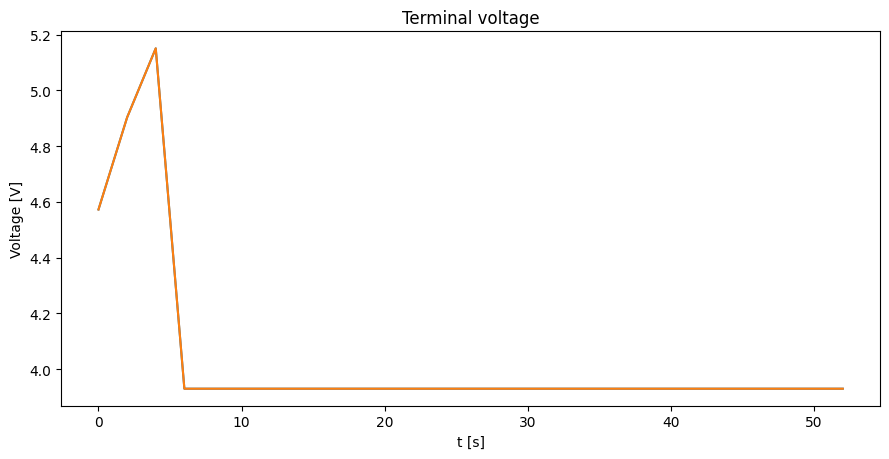

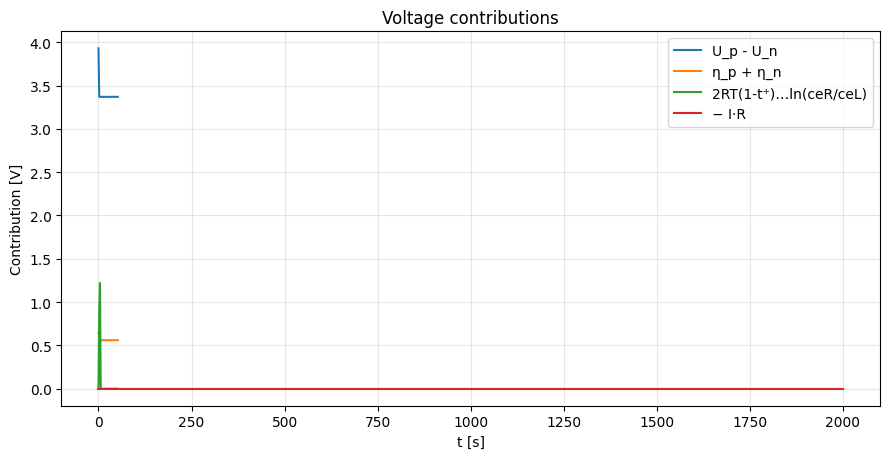

nan
max |residual| = 0.0


In [5]:
# ============================
# 8) Example (ready to run)
# ============================
if __name__ == "__main__":
    # # --- Parameters (ballpark) ---
    # params = dict(
    #     Dn=1e-14, Rn=5e-6, Dp=1e-14, Rp=5e-6,
    #     a_s_n=1.0e6, a_s_p=1.0e6, A=1.0,
    #     L1=25e-6, L2=20e-6, L3=25e-6,
    #     D_e=7.23e-10, eps=0.30,
    # )

    # # --- Assemble system ---
    # A, B, (An, Ap, Ae, Bn, Bp, Be) = assemble_system(params)
    # show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B)

    # # --- Time, input (step), initial states ---
    # T = np.linspace(0.0, 2000.0, 1001)   # s
    # I_step = 1.0                         # A (discharge)
    # U = I_step * np.ones_like(T)         # (T,)

    # x0 = np.zeros(7)
    # x0[IDX["cn"]] = 0.0
    # x0[IDX["cp"]] = 1.0
    # x0[IDX["ce"]] = 0.0

    # --- Simulate ---
    X_TN = simulate_states_forced(A, B, T, U, x0)  # (T,7)
    # plot_states_grouped(T, X_TN)
    # report_extrema(X_TN)

    # --- Voltage params (tune to your cell) ---
    vpar = VParams(
        A=params["A"], L_n=params["L1"], L_p=params["L3"],
        a_s_n=params["a_s_n"], a_s_p=params["a_s_p"],
        k_n=2e-11, k_p=2e-11, cs_n_max=3.1e4, cs_p_max=5.1e4,
        ce0=1000.0, t_plus=PP.t_plus, nu_T=1.0, k_f=1.0,
        Re=0.0, Rf=0.0, R_ohm=0.0, T=298.15,
        ce_is_deviation=True
    )

    # --- Voltages (two forms) ---
    V_eq40, C_eq40   = voltage_eq40(T, X_TN, U, vpar, ln_orientation="L")
    # V_espm, C_espm   = voltage_espm(T, X_TN, U, vpar, include_ln=True)

    # --- Visuals ---
    # plot_voltage_compare(T, V_eq40, V_espm, lab1="Eq. 40", lab2="ESPM/Review")
    plot_voltage_compare(T, V_eq40, V_eq40, lab1="Eq. 40", lab2="ESPM/Review")
    
    plot_voltage_contribs(T, C_eq40, title="Voltage contributions")
    # plot_voltage_contribs(T, C_espm, title="ESPM/Review contributions")

residual = C_eq40["V"] - (C_eq40["Udiff"] + C_eq40["eta_sum"] + C_eq40.get("dphi_e", 0.0) + C_eq40.get("ohmic", 0.0))
print(np.max(np.abs(residual)))# should be very close to zero
print("max |residual| =", np.nanmax(np.abs(residual)))


In [118]:
def check_stability(A):
    lam = np.linalg.eigvals(A)
    # max_real = np.max(np.real(lam))
    print("Eigenvalues:")
    print(lam)

lam = check_stability(Ae)

print(An) # rank deficient matrix


Eigenvalues:
[ 1.42814815e+01  4.76049383e+00 -5.64890899e-16]
[[-0.0032  0.0032]
 [ 0.0032 -0.0032]]


C:\Users\onyer\AppData\Local\Temp\ipykernel_13352\3805390827.py:94: RuntimeWarning: invalid value encountered in scalar divide
  elyte_drop = -(2.0 * R * T * (1.0 - t_plus) * k_f / F) * np.log(ce3 / ce1)
C:\Users\onyer\AppData\Local\Temp\ipykernel_13352\3805390827.py:94: RuntimeWarning: invalid value encountered in log
  elyte_drop = -(2.0 * R * T * (1.0 - t_plus) * k_f / F) * np.log(ce3 / ce1)


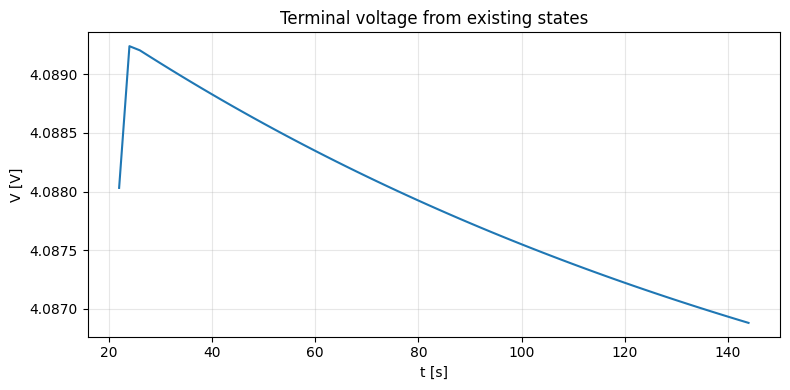

In [119]:
# # expected state order: x = [cn1, cn2, cp1, cp2, ce1, ce2, ce3]
# IDX = {"cn_surf": 1, "cp_surf": 2, "ce_left": 4, "ce_right": 6}

# def voltage_from_states(x, Ibat, params, U_func, eta_func):
#     """
#     Compute terminal voltage V (scalar) from discretized SPMe-like states.

#     Parameters
#     ----------
#     x : array-like, shape (7,)
#         [cn1, cn2, cp1, cp2, ce1, ce2, ce3]
#     Ibat : float
#         Applied pack current (A). Sign convention: discharge > 0.
#     params : dict
#         Must contain: R, T, F, t_plus, k_f, Re, Rf
#         - R  : gas constant
#         - T  : absolute temperature (K)
#         - F  : Faraday constant
#         - t_plus : cation transference number t^+
#         - k_f : “diffusional conductivity” factor in electrolyte term
#         - Re : bulk electrolyte resistance term
#         - Rf : film/ohmic lumped resistance term
#     U_func : callable
#         U_func(cn1, cn2, cp1, cp2) -> float
#         Open-circuit voltage difference (Up - Un), from your OCP maps.
#     eta_func : callable
#         eta_func(Ibat) -> float
#         Net kinetic overpotential contribution η(Ibat) (can combine anode/cathode
#         or return 0 if you fold kinetics into Rf).

#     Returns
#     -------
#     V : float
#         Terminal voltage (scalar).
#     """
#     cn1, cn2, cp1, cp2, ce1, _, ce3 = x
#     R = params["R"]; T = params["T"]; F = params["F"]
#     t_plus = params["t_plus"]; k_f = params["k_f"]
#     Re = params.get("Re", 0.0); Rf = params.get("Rf", 0.0)

#     # OCV (Up - Un) from the solid states you already have
#     U = U_func(cn1, cn2, cp1, cp2)

#     # Electrolyte concentration-gradient term (pick ONE of the two equivalent forms)
#     # Form A (as in your screenshot):  - (2RT(1 - t+) k_f / F) * ln(ce3/ce1)
#     elyte_drop = -(2.0 * R * T * (1.0 - t_plus) * k_f / F) * np.log(ce3 / ce1)

#     # Kinetics + resistive drops
#     eta = eta_func(Ibat)
#     ohmic = -(Re + Rf) * Ibat

#     V = U + eta + elyte_drop + ohmic
#     return float(V)

# ----- constants for voltage model -----
R_GAS = 8.314462618  # J/(mol K)

params_V = {
    "R": R_GAS,
    "T": 298.15,         # K
    "F": PP.F,           # Faraday from your PhysParams
    "t_plus": PP.t_plus, # from your PhysParams
    "k_f": 1.0,          # set/fit this (dimensionless factor used in the paper)
    "Re": 0.0,           # bulk electrolyte resistance [ohm]
    "Rf": 0.01,          # film/series resistance [ohm]  (tune/fit)
}

# ----- minimal OCV and kinetics placeholders -----
def U_func(cn1, cn2, cp1, cp2):
    """
    Return Up - Un [V]. Replace with your proper OCP maps.
    For now a toy linear dependence on "surface" CVs:
    """
    # pick "surface" cells per your indexing (cn2 ~ anode surf, cp1 ~ cathode surf)
    Un = 0.10 + 1e-4*cn2
    Up = 4.20 - 1e-4*cp1
    return Up - Un

def eta_func(I):
    """Kinetic overpotential model. Set 0 if you lump into Rf."""
    return 0.0

# ----- compute V(t) from the simulated trajectory X(t) -----
def voltage_from_states(x, Ibat, params, U_func, eta_func):
    cn1, cn2, cp1, cp2, ce1, _, ce3 = x
    R = params["R"]; T = params["T"]; F = params["F"]
    t_plus = params["t_plus"]; k_f = params["k_f"]
    Re = params.get("Re", 0.0); Rf = params.get("Rf", 0.0)

    # Open-circuit part
    U = U_func(cn1, cn2, cp1, cp2)

    # Electrolyte concentration term (choose ONE form; this matches your screenshot)
    elyte_drop = -(2.0 * R * T * (1.0 - t_plus) * k_f / F) * np.log(ce3 / ce1)

    # Kinetics + ohmic
    eta = eta_func(Ibat)
    ohmic = -(Re + Rf) * Ibat

    return float(U + eta + elyte_drop + ohmic)

# Example: compute V(t) for the step input you already simulated
Ibat = I_step  # your step current
V_t = np.array([voltage_from_states(x, Ibat, params_V, U_func, eta_func) for x in X])

plt.figure(figsize=(8,4))
plt.plot(T, V_t)
plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("Terminal voltage from existing states")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()
